# Лабораторная работа №3
## Задание
1. Написать программу, которая разделяет исходную выборку на обучающую и тестовую (training set, test set). Использовать стандартные функции (train_test_split и др. нельзя).
2. С использованием библиотеки scikit-learn обучить модель линейной регрессии по обучающей выборке.
3. Проверить точность модели по тестовой выборке.
4. Построить модель с использованием полиномиальной функции. Построить графики зависимости точности на обучающей и тестовой выборке от степени полиномиальной функции.
5. Построить модель с использованием регуляризации. На основе экспериментов подобрать параметры для регуляризации. Построить графики зависимости точности модели на обучающей и тестовой выборках от коэффициента регуляризации.

Данные: Cycle Power Plant Data Set.

## Выполнение работы
Как обычно импортируем нужные для работы библиотеки.

In [158]:
import numpy as np
import pandas as pd
import gc

from typing import Tuple
from numpy import random as rnd
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import r2_score
from sklearn.preprocessing import PolynomialFeatures

gc.enable()

target_feature = 'PE'
metric = r2_score
data_set_name = 'Cycle Power Plant Data Set'

### Пункт 1
Необходимо написать свою фунцию для разделения данных. Опишем сигнатуру функции:
- `X`, `y` - фичи и таргетные значения соответственно.
- `train_size`, `test_size` - размеры тренировочной и тествой выборок соответственно. Для правильной работы функции `train_size` + `test_size` должна быть равна 1.
- `seed` - начальное значение для генератора случайных чисел, необходимо для воспроизведения результата.

Алгоритм работы функции достаточно прост:
1. Проверка условия `train_size` + `test_size` = 1;
2. Генерация случайной перестановки длинны равной количетсву строк во входном наборе.
3. С помощью функции iloc делим данные на тестовую выборку и тренировочную.

In [159]:
def split_data(X: pd.DataFrame, y: pd.DataFrame, train_size: float = 0.8, test_size: float = 0.2,
               seed: int = None) -> Tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    assert(train_size + test_size <= 1), 'train size + test size must be equal to 1'
    rnd.seed(seed)
    seq_size = X.shape[0]
    perm = rnd.permutation(seq_size)

    train_samples = int(seq_size * train_size)

    X_train = X.iloc[perm[:train_samples], :]
    X_test = X.iloc[perm[train_samples:], :]

    y_train = y.iloc[perm[:train_samples]]
    y_test = y.iloc[perm[train_samples:]]

    return X_train, y_train, X_test, y_test

### Пункт 2-3
Прочитаем данные и разделим их на тестовую и тренировочную выборку.

In [160]:
data = pd.read_excel('../../data/Folds5x2_pp.xlsx')
target = data[target_feature]
data.drop([target_feature], axis=1, inplace=True)

X_train, y_train, X_test, y_test = split_data(data, target, train_size=0.7, test_size=0.3, seed=2)

Создадим объект класса `LinearRegression` из библиотеки `sklearn`, который представляет реализацию линейной регрессии.
С помощью функции `fit` произвдедем обучение модели, а с помощью `predict` предскажем значения для тестовой выборки.

In [161]:
model = LinearRegression(n_jobs=-1)
model.fit(X_train, y_train)
preds = model.predict(X_test)

Чтобы оценить модель воспользуемся метрикой `r2_score`, ее выбор обосновывается тем, что возвращаемое значение $y\in[-1,1]$ где 1 - означает идеальное соответствие данных, а -1 отсутствие кореляции вообще.

In [162]:
result = metric(y_test, preds)
print(f'Linear regression R2: {result:.4f}')

Linear regression R2: 0.9260


Как можно видеть, даже самая простая линейная регрессия дает очень хороший результат, что можно объяснить простойтой данных (всего лишь 4 параметра) и завимости целевой пременной от них. Также можно предположить отсутсвие нелинейных зависимостей, проверим это в следующем пункте.

### Пункт 4
Определим степени полиномов и создадим массивы данных для результатов метрики.

In [173]:
powers = [1, 2, 3, 4, 5, 6, 7, 8, 9]
mae_train = [0] * len(powers)
mae_test = [0] * len(powers)

За создание полиноминальных параметров отвечает класс `PolynomialFeatures`. В конструктор передаем значение степени полинома, а чтобы получить новые данные используем функцию `fit_transform`.

Теперь, разобравшись как получить полиноминальные парметры, начнем делать предсказания. В цикле будем создавать новые данные, обучать и предсказывать на них данные, записывая результат в созданные массивы.

In [174]:
for i in range(len(powers)):
    # Добавляем полиноминальные фичи
    poly = PolynomialFeatures(powers[i])
    X_train_poly = poly.fit_transform(X_train)
    X_test_poly = poly.fit_transform(X_test)

    model = LinearRegression(n_jobs=-1, normalize=True)
    model.fit(X_train_poly, y_train)
    
    preds_test = model.predict(X_test_poly)
    preds_train = model.predict(X_train_poly)
    
    result_test = metric(y_test, preds_test)
    result_train = metric(y_train, preds_train)
    print(f'Polynomial regression {powers[i]} R2: {result_test:.4f}')

    mae_test[i] = result_test
    mae_train[i] = result_train
    del X_train_poly, X_test_poly, preds_test, preds_train
    gc.collect()
print(f'Best score: {np.amax(mae_test):.4f}')

Polynomial regression 1 R2: 0.9260
Polynomial regression 2 R2: 0.9345
Polynomial regression 3 R2: 0.9368
Polynomial regression 4 R2: 0.9385
Polynomial regression 5 R2: 0.9414
Polynomial regression 6 R2: 0.9403
Polynomial regression 7 R2: 0.9413
Polynomial regression 8 R2: 0.9341
Polynomial regression 9 R2: 0.9058
Best score: 0.9414


Теперь осталось лишь отрисовать графики зависимости точности модели от степени полинома.

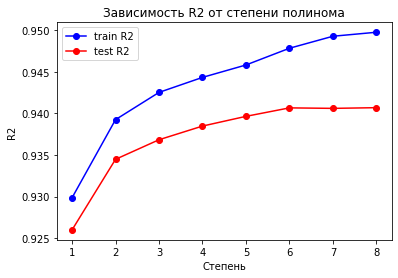

In [165]:
# Рисуем графики
train_line, = plt.plot(powers, mae_train, 'bo-', label='train R2')
test_line, = plt.plot(powers, mae_test, 'ro-', label='test R2')

plt.title('Зависимость R2 от степени полинома')
plt.xlabel('Степень')
plt.ylabel('R2')
plt.legend(handles=[train_line, test_line])

plt.show()

Судя по графику, оптимальной (по точности) степенью полинома является 7 степень. Прирост точности не велик (0.0163), это подвержает гипотезу о отсутствии нелинейных зависимостей.

### Пункт 5
Т.к. кореляция между параметрами и целевым значениям и так очень велико, то бессмысленно применять регуляризацию для линейной регрессии, поэтому будем использовать полиноминальные параметры.

s:\programs\interpreters\pythonenvs\mlenv\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 57485.035639830996, tolerance: 194.64713289993128
  positive)


alpha: 1e-06, test r2: 0.9346


s:\programs\interpreters\pythonenvs\mlenv\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 49342.930534802596, tolerance: 194.64713289993128
  positive)


alpha: 1e-05, test r2: 0.9344


s:\programs\interpreters\pythonenvs\mlenv\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 415.60520776915655, tolerance: 194.64713289993128
  positive)


alpha: 0.0001, test r2: 0.9333
alpha: 0.001, test r2: 0.9328
best score: 0.9346


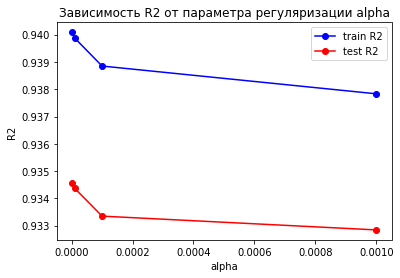

In [188]:
poly = PolynomialFeatures(5)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.fit_transform(X_test)

alpha = [1e-6, 1e-5, 1e-4, 1e-3]
train_mae = [0] * len(alpha)
test_mae = [0] * len(alpha)
for i in range(len(alpha)):
    model = Lasso(alpha=alpha[i], random_state=5, normalize=True)
    model.fit(X_train_poly, y_train)

    test_preds = model.predict(X_test_poly)
    train_preds = model.predict(X_train_poly)

    test_result = metric(y_test, test_preds)
    train_result = metric(y_train, train_preds)

    train_mae[i] = train_result
    test_mae[i] = test_result
    
    print(f'alpha: {alpha[i]}, test r2: {test_result:.4f}')

print(f'best score: {np.amax(test_mae):.4f}')

train_line, = plt.plot(alpha, train_mae, 'bo-', label='train R2')
test_line, = plt.plot(alpha, test_mae, 'ro-', label='test R2')

plt.xlabel('alpha')
plt.ylabel('R2')
plt.title('Зависимость R2 от параметра регуляризации alpha')
plt.legend(handles=[train_line, test_line])

plt.show()

## Вывод
В ходе выполнения лабораторной работы были получены и закреплены следующие навыки:
1. Разделение данных на тренировочную и тестовую выборки;
2. Построение модели линейной регрессии;
3. Построение модели полиноминальной регрессии;
4. Построение модели полиноминальной регрессии с регуляризацией.